<a href="https://colab.research.google.com/github/esumpter25/retinai/blob/main/Main_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Dependencies and Mounting Drive
-----------------------

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import signal
import requests
import io
import os
from urllib.request import urlopen
from PIL import Image
import pandas as pd
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import metrics

from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Model

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

import pickle
from google.colab import drive
import cv2

In [ ]:
# mount drive and initialise directories
drive.mount('/content/drive')

code_directory = "/content/drive/MyDrive/Group 4/Retina Classification/Code/"
root_directory= "/content/drive/MyDrive/Group 4/Retina Classification/Dataset/archive/"

#Storing the Dataset Attributes
Extracting all image data one by one by going over each image. Storing this data as a pickle file.

**Run only once for each type of data (train, test)**

In [ ]:
# load pixel-level data from files
data_type = "Training" # or "Testing"
directory = root_directory + f"{data_type}_Set/{data_type}_Set/{data_type}/"
files = [file for file in os.listdir(directory) if file.endswith('.png')]

csv_file = root_directory + f"{data_type}_Set/{data_type}_Set/RFMiD_{data_type}_Labels.csv"
labels_df = pd.read_csv(csv_file)
labels_df = labels_df[["ID", "Disease_Risk"]]

ID_list = []
for file in files:
  ID = file.split(".")[0]
  ID = int(ID)
  ID_list.append(ID)

store = []
for index, row in labels_df.iterrows():
  if row["ID"] in ID_list:
    store.append(row['ID'])

labels_df = labels_df[labels_df['ID'].isin(store)]
print(labels_df)

        ID  Disease_Risk
0        1             1
1        2             1
2        3             1
3        4             1
4        5             1
...    ...           ...
1915  1916             1
1916  1917             1
1917  1918             0
1918  1919             0
1919  1920             0

[1920 rows x 2 columns]


In [ ]:
x = []
y = []
for index, row in labels_df.iterrows():
  img_path = os.path.join(directory, f"{row['ID']}.png")
  img = cv2.imread(img_path)
  img = cv2.resize(img, (224, 224))
  x.append(np.array(img))
  y.append(row['Disease_Risk'])

In [ ]:
load_data = {'X': x, 'Y': y}
pickle.dump(load_data, open(root_directory + f'{data_type}_Set/{data_type}_data.pkl', 'wb'))

#Load the training and test data from the pickle files.

In [ ]:
train_load_df = pickle.load(open(root_directory + 'Training_Set/Training_data.pkl', 'rb'))
x_data = train_load_df['X']
y_data = train_load_df['Y']
test_load_df = pickle.load(open(root_directory + 'Testing_Set/Testing_data.pkl', 'rb'))
x_test = test_load_df['X']
y_test = test_load_df['Y']

# Visualise the data

Input Shape:  (224, 3)
Label:  1


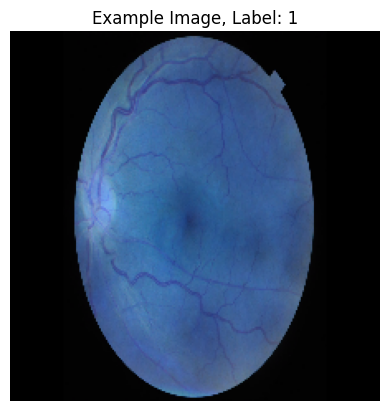

In [ ]:
# visualise a random image from the dataset
image_number = 10 # change randomly

input_shape = (x_test[image_number].shape[1], x_test[image_number].shape[2])
print('Input Shape: ', input_shape)
print('Label: ', y_test[image_number])
example = x_test[image_number][:,:]
plt.imshow(example)
plt.axis('off')
plt.title(f"Example Image, Label: {y_test[image_number]}")
plt.show()


#Data Preprocessing

In [ ]:
# convert list to arrays
x_data = np.array(x_data)
y_data = np.array(y_data)
x_test = np.array(x_test)
y_test = np.array(y_test)
print(x_data.shape)

(1920, 224, 224, 3)


In [ ]:
num_classes = 2
# one hot encoding
y_data = to_categorical(y_data, num_classes = num_classes)
y_test = to_categorical(y_test, num_classes = num_classes)
print(y_data.shape)

(1920, 2)


In [ ]:
_, height, width, depth = x_data.shape
input_shape = (height, width, depth)
print(f"Input Shape:", input_shape)

Input Shape: (224, 224, 3)


#Constructing the models - CNNs and Transfer Learning

Model 1: Construct a CNN with keras.Sequential() with two convolutional and one dense layers.

Model 2: Leverage pretrained VGG16 as the base model and finetune it.


In [ ]:
def get_model(name='simple'):
  if name == 'simple':
    model = keras.Sequential()
    # BLOCK 1
    model.add(layers.Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # BLOCK 2
    model.add(layers.Conv2D(64, (3, 3), padding="same", activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # BLOCK 3
    model.add(layers.Conv2D(128, (3, 3), padding="same", activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # BLOCK 4
    model.add(layers.Conv2D(256, (3, 3), padding="same", activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # CLASSIFIER
    model.add(layers.MaxPooling2D(pool_size=(8, 8)))
    model.add(layers.Flatten())
    model.add(layers.Dense(num_classes))
    model.add(layers.Activation("softmax"))
    return model

  elif name == 'vgg':
    base_model = VGG16(weights='imagenet', include_top = False, input_shape=input_shape)
    base_model.trainable = False
    model = tf.keras.Sequential([
      base_model,
      keras.layers.GlobalAveragePooling2D(),
      keras.layers.Dense(num_classes, activation='sigmoid')
    ])
    return model

model = get_model('simple')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 128)       0

#Training the models



###Define hyperparameters and train the model.

In [ ]:
# HYPERPARAMETRS

# num_epochs - number of times to repeat the training
num_epochs = 50

# batch_size - how many images to train together at each step
batch_size = 50

# learning_rate - the update speed of the network
learning_rate = 1e-3


###Split training data into train and validation sets.

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

###Compile and start training.

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy', metrics.Precision(), metrics.Recall()])

history = model.fit(x_train, y_train,
          validation_data=(x_val, y_val),
          batch_size=batch_size,
          epochs=num_epochs,
          verbose=1)

Epoch 1/50
31/31 [==============================] - 15s 202ms/step - loss: 6.5455 - accuracy: 0.7350 - precision: 0.7350 - recall: 0.7350 - val_loss: 0.4302 - val_accuracy: 0.8385 - val_precision: 0.8385 - val_recall: 0.8385
Epoch 2/50
31/31 [==============================] - 2s 76ms/step - loss: 0.4455 - accuracy: 0.8184 - precision: 0.8184 - recall: 0.8184 - val_loss: 0.4317 - val_accuracy: 0.8438 - val_precision: 0.8438 - val_recall: 0.8438
Epoch 3/50
31/31 [==============================] - 3s 81ms/step - loss: 0.4256 - accuracy: 0.8145 - precision: 0.8145 - recall: 0.8145 - val_loss: 0.4587 - val_accuracy: 0.8229 - val_precision: 0.8229 - val_recall: 0.8229
Epoch 4/50
31/31 [==============================] - 2s 77ms/step - loss: 0.4208 - accuracy: 0.8242 - precision: 0.8242 - recall: 0.8242 - val_loss: 0.4736 - val_accuracy: 0.8021 - val_precision: 0.8021 - val_recall: 0.8021
Epoch 5/50
31/31 [==============================] - 3s 85ms/step - loss: 0.4128 - accuracy: 0.8262 - preci

###Run Inference on Train Data


In [ ]:
img_index = 23 # pick an image to test on from our test array, or try selecting it randomly like we did for visualization!

print(f"Running Model Inference on Image number {img_index}")
img_array = x_data[img_index]
expanded_img_array = np.expand_dims(img_array, axis=0)

actual_label = y_data[img_index]
actual_label = np.argmax(actual_label)

# Make predictions using the model
predictions = model.predict(expanded_img_array)
predicted_label = np.argmax(predictions[0])  # Get the predicted label

print("Predicted Label:", predicted_label)
print("Actual Label:", actual_label)

Running Model Inference on Image number 23
1/1 [==============================] - 0s 362ms/step
Predicted Label: 0
Actual Label: 1


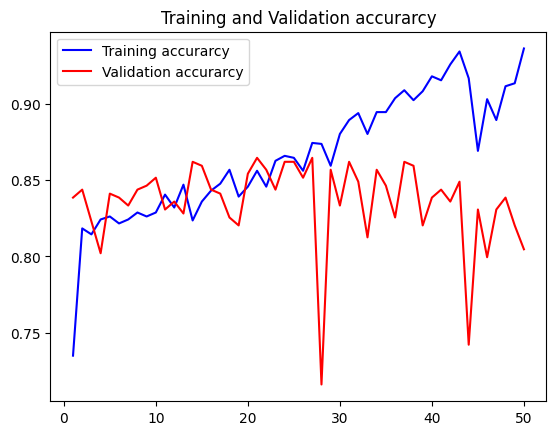

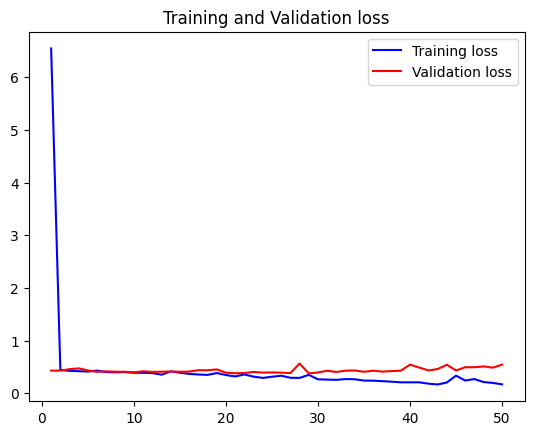

In [ ]:
# PLOT GRAPH
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

###Loading Test Data
We can use the entirety of the test arrays to compute our model's accuracy and loss on new data to see how it performs.

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.48999062180519104
Test accuracy: 0.801562488079071


20/20 [==============================] - 0s 13ms/step
Precision: 0.7291563097250301
Recall: 0.8059259040764557


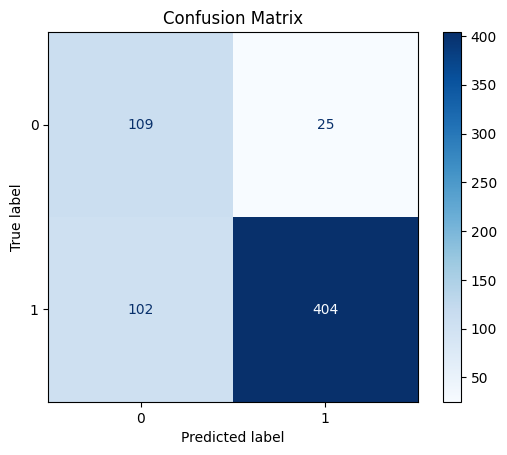

In [ ]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate precision and recall
precision = precision_score(y_true, y_pred_classes, average='macro')
recall = recall_score(y_true, y_pred_classes, average='macro')
print('Precision:', precision)
print('Recall:', recall)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
cmd = ConfusionMatrixDisplay(cm, display_labels=np.arange(num_classes))

# Plot the confusion matrix
cmd.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

###Saving and Loading the model

We can also save the model for future use.

In [ ]:
# Save the model and its weights
model_name = "final_simple-50"
model.save(code_directory + model_name + ".keras")

# Load the saved model
loaded_model = keras.models.load_model(code_directory + model_name + ".keras")

NameError: name 'model' is not defined

In [ ]:
# Make predictions using the model
predictions = loaded_model.predict(expanded_img_array)
predicted_label = np.argmax(predictions[0])  # Get the predicted label

print("Predicted Label:", predicted_label)
print("Actual Label:", actual_label)

1/1 [==============================] - 0s 102ms/step
Predicted Label: 0
Actual Label: 1
